## **Preprocessing**

In [ ]:
!pip install --upgrade transformers
!pip install --upgrade torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 74.1 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.50.3
    Uninstalling transformers-4.50.3:
      Successfully uninstalled transformers-4.50.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB ? eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 721.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import kagglehub
import pandas as pd
import nltk
import torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from IPython.display import IFrame
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Download latest version of the dataset
path = kagglehub.dataset_download("sumitm004/arxiv-scientific-research-papers-dataset")
print("Path to dataset files:", path)

100%|██████████| 62.4M/62.4M [00:00<00:00, 148MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sumitm004/arxiv-scientific-research-papers-dataset/versions/2


# **Data Exploration**

## Understanding our dataset: columns, data types, ect...

In [ ]:
# download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

df = pd.read_csv(path + '/arXiv_scientific dataset.csv')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136238 entries, 0 to 136237
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   id                  136238 non-null  object
 1   title               136238 non-null  object
 2   category            136238 non-null  object
 3   category_code       136238 non-null  object
 4   published_date      136238 non-null  object
 5   updated_date        136238 non-null  object
 6   authors             136238 non-null  object
 7   first_author        136238 non-null  object
 8   summary             136238 non-null  object
 9   summary_word_count  136238 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 10.4+ MB


In [ ]:
print(df['category'].value_counts().to_string())

category
Machine Learning                                                    39986
Computer Vision and Pattern Recognition                             29057
Computation and Language (Natural Language Processing)              25202
Artificial Intelligence                                             12969
Machine Learning (Statistics)                                       10447
Neural and Evolutionary Computing                                    5509
Robotics                                                              903
Information Retrieval                                                 901
Methodology (Statistics)                                              882
Computation and Language (Legacy category)                            750
Optimization and Control                                              749
Cryptography and Security                                             665
Computers and Society                                                 515
Social and Information Networ

### **Note:** We noticed an imbalance in the number of data points across categories, so we decided to select the top six categories for this study (data sampling). This approach will also help reduce noise.

In [ ]:
#selecting the papers with enough papers

# List of categories to select
categories_to_select = [
    "Machine Learning",
    "Computer Vision and Pattern Recognition",
    "Computation and Language (Natural Language Processing)",
    "Artificial Intelligence",
    "Machine Learning (Statistics)",
    "Neural and Evolutionary Computing"
]

filtered_df = df[df['category'].isin(categories_to_select)]

# Checking the updated shape
print(filtered_df.shape)

# Checking the previous shape
print(df.shape)

(123170, 10)
(136238, 10)


In [ ]:
print(filtered_df['category'].unique())

['Artificial Intelligence' 'Machine Learning'
 'Computation and Language (Natural Language Processing)'
 'Neural and Evolutionary Computing'
 'Computer Vision and Pattern Recognition' 'Machine Learning (Statistics)']


In [ ]:
#preprocessing function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Return the processed text as a single string
    return " ".join(tokens)

# Apply preprocessing to the 'summary' column
filtered_df['processed_summary'] = filtered_df['summary'].apply(preprocess_text)

print(filtered_df[['summary', 'processed_summary']].head())

                                             summary  \
0  Because of their occasional need to return to ...   
1  Market price systems constitute a well-underst...   
2  We describe an extensive study of search in GS...   
3  As real logic programmers normally use cut (!)...   
4  To support the goal of allowing users to recor...   

                                   processed_summary  
0  occasional need return shallow point search tr...  
1  market price system constitute class mechanism...  
2  describe extensive study search gsat approxima...  
3  real logic programmer normally use cut effecti...  
4  support goal allowing user record retrieve inf...  


<ipython-input-8-81ea0f6695e7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['processed_summary'] = filtered_df['summary'].apply(preprocess_text)


# **Generate BERT embeddings**

In [ ]:
# Load BERT model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Function to get BERT embeddings
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

# Generate embeddings
filtered_df['bert_embedding'] = filtered_df['processed_summary'].apply(get_bert_embedding)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

<ipython-input-10-17c6ce23e788>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['bert_embedding'] = filtered_df['processed_summary'].apply(get_bert_embedding)


In [ ]:
import numpy as np
import pickle
# Convert to NumPy array
bert_embeddings_array = np.stack(filtered_df['bert_embedding'].values)

# Save embeddings
with open('bert2_embeddings.pkl', 'wb') as f:
    pickle.dump(bert_embeddings_array, f)


from google.colab import files
files.download('bert2_embeddings.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Generate SciBERT Embeddings**

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load SciBERT model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scibert_tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
scibert_model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased').to(device)

# Function to get SciBERT embeddings
def get_scibert_embedding(text):
    inputs = scibert_tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = scibert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

# Apply SciBERT embeddings to processed summaries
filtered_df['scibert_embedding'] = filtered_df['processed_summary'].apply(get_scibert_embedding)



config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

<ipython-input-11-2f6e60e9fbd2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['scibert_embedding'] = filtered_df['processed_summary'].apply(get_scibert_embedding)


In [ ]:


# Convert to NumPy array
scibert_embeddings_array = np.stack(filtered_df['scibert_embedding'].to_numpy())

# Save embeddings
with open('scibert2_embeddings.pkl', 'wb') as f:
    pickle.dump(scibert_embeddings_array, f)

# Download the file
from google.colab import files
files.download('scibert2_embeddings.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **BERT VS SciBERT**


### We aim to compare BERT and SciBERT to determine which performs better for topic modeling. First approach: We apply K-Means clustering to the embeddings generated by both models to compare their performance in topic modeling.

Note: Show them the notebook you used for training: https://colab.research.google.com/drive/1UJ7HGK7L8AtTxaRJFmflo-C93g_PTtXH?usp=sharing


In [ ]:
import pickle
import numpy as np
import pickle
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# **Performing Kmean on SciBERT and Assigning labels to clusters**




We will fist need to apply PCA (PCA reduces embeddings to 2D or 3D, allowing us to plot clusters easily).

# **a) Performing K-mean**

In [ ]:
import numpy as np

# Load embeddings
with open("/content/scibert2_embeddings.pkl", "rb") as f:
    scibert_embeddings = pickle.load(f)

# check if it is NumPy array
scibert_embeddings = np.array(scibert_embeddings)

# Check the shape
print("Embeddings shape:", scibert_embeddings.shape)


Embeddings shape: (123170, 768)


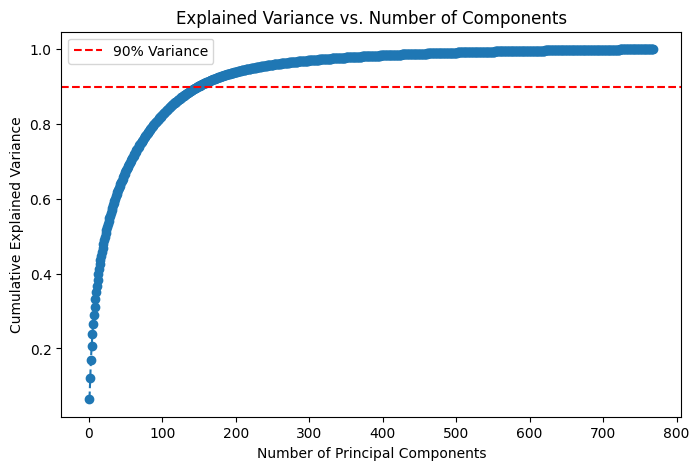

Optimal PCA Components: 149


In [ ]:
# Step 2: Apply PCA (Find Optimal Components)
pca = PCA()
pca.fit(scibert_embeddings)

# variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot Variance
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker="o", linestyle="--")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.axhline(y=0.90, color='r', linestyle='--', label="90% Variance")
plt.legend()
plt.show()

#Step 3: Select the Optimal Number of Components
optimal_pca_components = np.argmax(explained_variance >= 0.90) + 1
print(f"Optimal PCA Components: {optimal_pca_components}")

In [ ]:
# Apply PCA with optimal components
pca = PCA(n_components=optimal_pca_components)
scibert_pca = pca.fit_transform(scibert_embeddings)
print("Reduced Embeddings Shape:", scibert_pca.shape)  # (num_samples, optimal_pca_components)


Reduced Embeddings Shape: (123170, 149)


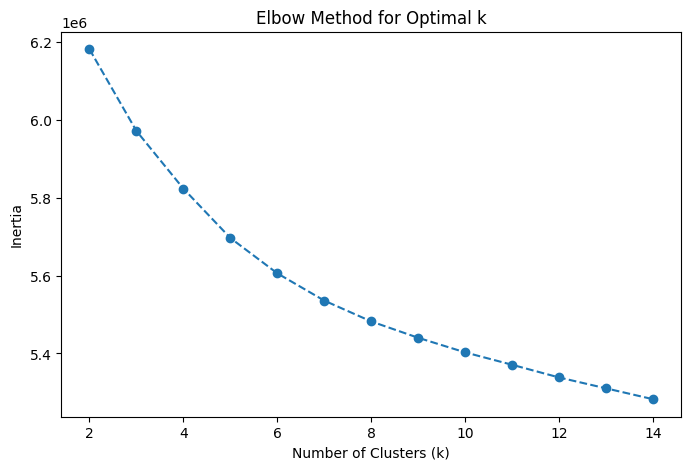

In [ ]:
#Step 4: Use Elbow Method to Find the Best Number of Clusters
inertia = []
num_clusters_range = range(2, 15)

for k in num_clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scibert_pca)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8,5))
plt.plot(num_clusters_range, inertia, marker='o', linestyle="--")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

In [ ]:
!pip install kneed

We can see that inertia stopped decreasing around k=6. To confirm, let's run a quick code.

In [ ]:
from kneed import KneeLocator

# Find the elbow point automatically
knee_locator = KneeLocator(num_clusters_range, inertia, curve="convex", direction="decreasing")
optimal_k = knee_locator.elbow

print(f"Optimal number of clusters: {optimal_k}")

Optimal number of clusters: 6


In [ ]:
# Run K-Means with Optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(scibert_pca)

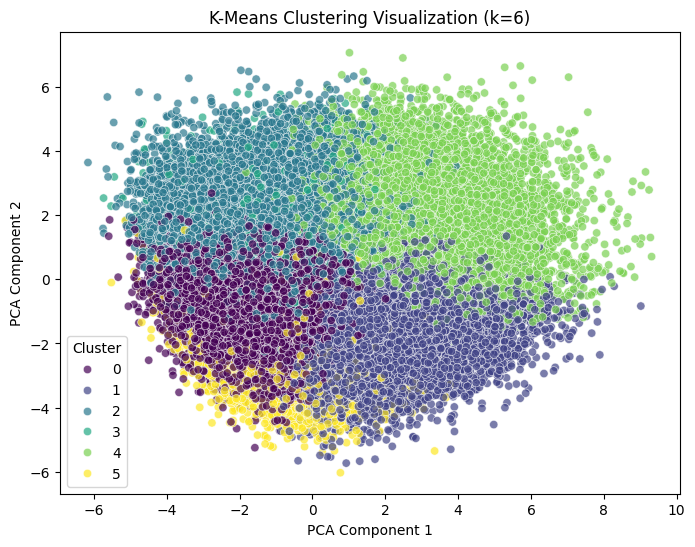

In [ ]:
import seaborn as sns
#Step 6: Visualize Clusters (2D PCA Plot)
pca_2d = PCA(n_components=2).fit_transform(scibert_pca)  # Reduce to 2D for visualization

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_2d[:, 0], y=pca_2d[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"K-Means Clustering Visualization (k={optimal_k})")
plt.legend(title="Cluster")
plt.show()

In [ ]:
#Step 7: Evaluate Clustering with Silhouette Score
sil_score = silhouette_score(scibert_pca, labels)
print(f"Silhouette Score: {sil_score:.4f}")

# Evaluate clustering with davies_bouldin
from sklearn.metrics import davies_bouldin_score
dbi_score = davies_bouldin_score(scibert_pca, labels)
print(f"Davies-Bouldin Index: {dbi_score:.4f}")

Silhouette Score: 0.0365
Davies-Bouldin Index: 3.7746


Silhouette: How well the clusters are separated. (1.0 well separated, 0.5-0.9 good and so one)

Davies-Bouldin: (>2 poor clustering, 0-1 good, 1-2 acceptable)

# **Performing Kmean on BERT and Assigning labels to clusters**

# **a) Performing Kmean**

In [ ]:
import numpy as np

# Load embeddings
with open("/content/bert2_embeddings.pkl", "rb") as f:
    bert_embeddings = pickle.load(f)

# Ensure it's a NumPy array
bert_embeddings = np.array(bert_embeddings)

# Check the shape
print("Embeddings shape:", bert_embeddings.shape)

# Print first 2 embeddings
print("First embedding sample:", bert_embeddings[0][:10])  # First 10 values of first vector

# Check the data type
print("Data type:", bert_embeddings.dtype)

Embeddings shape: (123170, 768)
First embedding sample: [-0.34582892  0.03043827  0.5297207   0.09494032  0.30654842 -0.14577009
  0.16562651  0.10287185 -0.1065708  -0.06100761]
Data type: float32


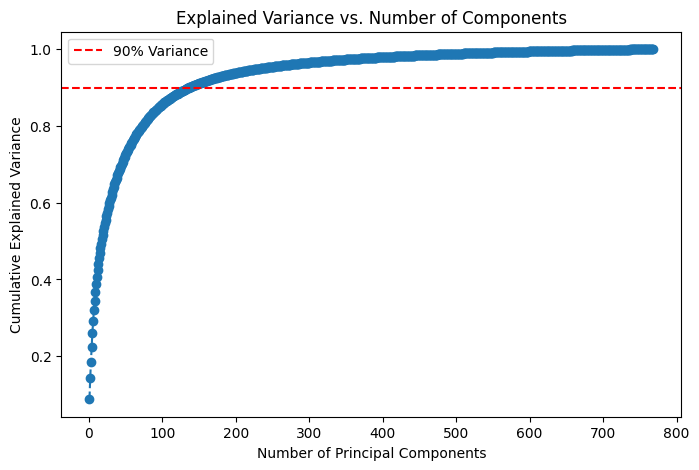

Optimal PCA Components: 137


In [ ]:
# Step 2: Apply PCA (Find Optimal Components)
pca = PCA()
pca.fit(bert_embeddings)

#variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot Explained Variance
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker="o", linestyle="--")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.axhline(y=0.90, color='r', linestyle='--', label="90% Variance")
plt.legend()
plt.show()

#Step 3: Select the Optimal Number of Components
optimal_pca_components = np.argmax(explained_variance >= 0.90) + 1
print(f"Optimal PCA Components: {optimal_pca_components}")

In [ ]:
# Apply PCA with optimal components
pca = PCA(n_components=optimal_pca_components)
bertfinal_pca = pca.fit_transform(bert_embeddings)
print("Reduced Embeddings Shape:", bertfinal_pca.shape)


Reduced Embeddings Shape: (123170, 137)


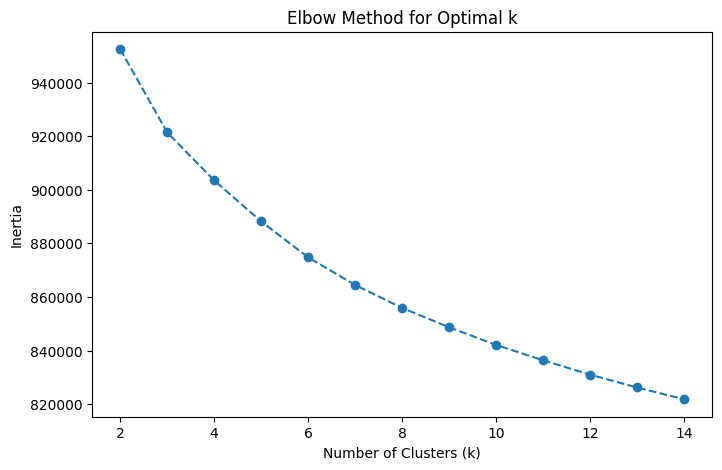

In [ ]:
#Step 4: Use Elbow Method to Find the Best K (Number of Clusters)
inertia = []
num_clusters_range = range(2, 15)

for k in num_clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(bertfinal_pca)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8,5))
plt.plot(num_clusters_range, inertia, marker='o', linestyle="--")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

In [ ]:
from kneed import KneeLocator

# Find the elbow point automatically
knee_locator = KneeLocator(num_clusters_range, inertia, curve="convex", direction="decreasing")
optimal_k = knee_locator.elbow

print(f"Optimal number of clusters: {optimal_k}")

Optimal number of clusters: 6


In [ ]:
# Run K-Means with Optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(bert_embeddings)

In [ ]:
#Step 6: Evaluate Clustering with Silhouette Score
sil_score = silhouette_score(bert_embeddings, labels)
print(f"Silhouette Score: {sil_score:.4f}")

# Evaluate clustering with davies_bouldin
from sklearn.metrics import davies_bouldin_score
dbi_score = davies_bouldin_score(bert_embeddings, labels)
print(f"Davies-Bouldin Index: {dbi_score:.4f}")

Silhouette Score: 0.0287
Davies-Bouldin Index: 4.0258


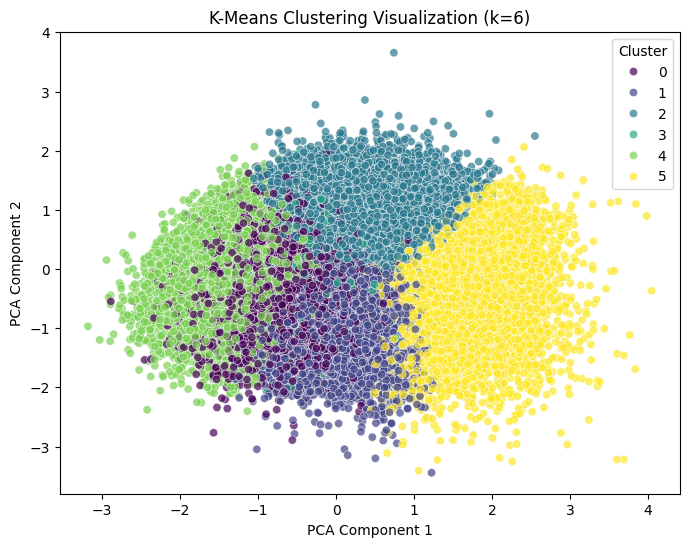

In [ ]:
import seaborn as sns
#Step 7: Visualize Clusters (2D PCA Plot)
pca_2d = PCA(n_components=2).fit_transform(bertfinal_pca)  # Reduce to 2D for visualization

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_2d[:, 0], y=pca_2d[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"K-Means Clustering Visualization (k={optimal_k})")
plt.legend(title="Cluster")
plt.show()

# **Observations:**

Using the Whole dataset

**BERT:**

Optimal PCA Components: 137

Optimal number of clusters: 6

Silhouette Score: 0.0287



**SciBERT:**

Optimal PCA Components: 149

Optimal number of clusters: 6

Silhouette Score: 0.0365


***Comment on Silhouette Scores:***
Both BERT and SciBERT produced relatively low silhouette scores, indicating that the clusters are not very well-separated and may overlap significantly. However, SciBERT achieved a slightly higher score than BERT (0.0365 vs. 0.0287), suggesting that it produced more coherent clusters for topic modelling in this context, it hints at Scibert's better suitability for domain-specific (scientific) data.

Let's focus on improving the cluster for Scibert by switching from PCA to UMAP. The reason for that is that UMAP works better with non-linear data compared to PCA


***BERT required 137 principal components, while SciBERT required 149. This implies that SciBERT embeddings retained slightly more meaningful variance after dimensionality reduction.***



# **Try UMAP + Kmeans to improve clustering (For Scibert)**

In [ ]:
import umap

umap_reducer = umap.UMAP(n_components=2, random_state=42)
scibert_umap = umap_reducer.fit_transform(scibert_embeddings)

kmeanxs = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(scibert_umap)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


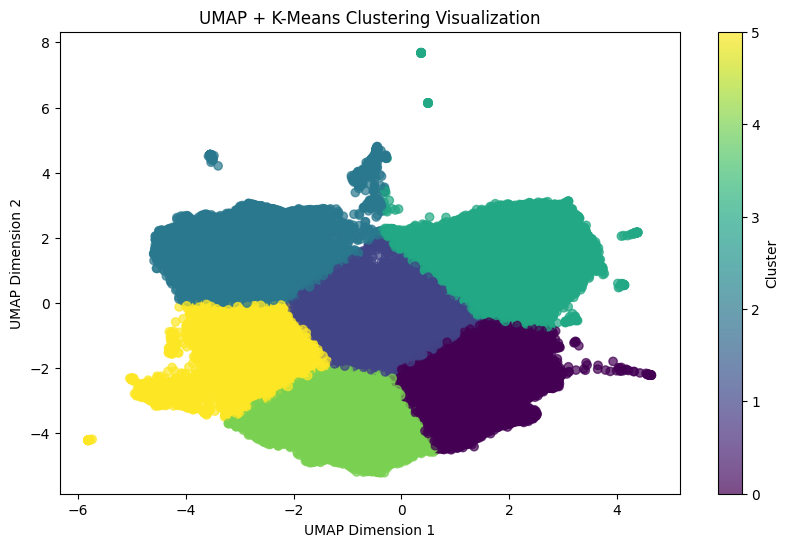

In [ ]:

# Scatter plot of UMAP-reduced embeddings
plt.figure(figsize=(10, 6))
plt.scatter(scibert_umap[:, 0], scibert_umap[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(label="Cluster")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("UMAP + K-Means Clustering Visualization")
plt.show()

In [ ]:
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Compute Davies-Bouldin Index
db_index = davies_bouldin_score(scibert_umap, labels)
print(f"Davies-Bouldin Index: {db_index:.4f}")  # Lower is better

# Compute Silhouette Score
silhouette_avg = silhouette_score(scibert_umap, labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")  # Higher is better

Davies-Bouldin Index: 0.7611
Silhouette Score: 0.4297


### **NOTE:** Compared to the earlier PCA-based approach (Silhouette Score: 0.0365), using UMAP significantly improved cluster quality. The much higher silhouette score (0.4297) suggests that the clusters are now more distinct. The lower Davies-Bouldin Index indicates reduced overlap and better separation between clusters (lower values are better).